In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

import sys
sys.path.append("../../")

import biked_commons
from biked_commons.prediction import aero_predictor, loaders
from biked_commons import resource_utils


In [2]:
X_tv, Y_tv = loaders.load_aero()

In [3]:
X_tv

,hand_x,hand_y,hip_x,hip_y,crank_length,upper_leg,lower_leg,arm_length,torso_length,neck_and_head_length,torso_width
1161,0.539590,0.536453,0.427000,0.681000,0.175000,0.457742,0.533926,0.687155,0.535995,0.288442,0.338117
2355,0.471688,0.475275,0.426000,0.681000,0.173000,0.385622,0.547221,0.648593,0.525186,0.302046,0.302120
1831,0.435000,0.489000,0.442000,0.343000,0.173000,0.388114,0.497758,0.705805,0.496954,0.287635,0.364465
156,0.383192,0.671496,0.346000,0.367000,0.173000,0.412393,0.518318,0.694971,0.571948,0.329807,0.304491
195,0.532379,0.504070,0.401000,0.650000,0.170000,0.371987,0.512847,0.614458,0.562886,0.297272,0.325182
...,...,...,...,...,...,...,...,...,...,...,...
835,0.616722,0.544678,0.361000,0.700000,0.165000,0.425474,0.516897,0.619067,0.546803,0.322064,0.355982
3264,0.498238,0.668082,0.402218,0.656970,0.179797,0.380217,0.518529,0.656427,0.525488,0.331143,0.320834
1653,0.442000,0.692000,0.396000,0.713000,0.173000,0.413493,0.514540,0.632598,0.526474,0.305159,0.331849
2607,0.346517,0.561491,0.343344,0.452610,0.193922,0.428106,0.498804,0.569410,0.507026,0.312906,0.330999


In [4]:
X_tv_tens = torch.tensor(X_tv.values, dtype=torch.float32)
features = aero_predictor.calculate_features(X_tv_tens)
X_augmented = torch.cat((X_tv_tens, features), dim=1)
mean = X_augmented.mean(axis=0)
std = X_augmented.std(axis=0)

In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(X_tv.values, Y_tv.values, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

In [6]:
# Define the model, loss function, and optimizer
input_dim = X_augmented.shape[1]
output_dim = 1
model = aero_predictor.DNN(input_dim, output_dim, mean, std)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500
batch_size = 32
best_val_loss = float('inf')
model_path = resource_utils.resource_path("models")
save_path = model_path + '/aero.pth'

for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size()[0])
    
    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], Y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, Y_val_tensor)

    # Save best model
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        torch.save(model, save_path)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f} (Best: {best_val_loss:.4f})')



Epoch [10/500], Loss: 5.9958, Val Loss: 1.0994 (Best: 1.0913)
Epoch [20/500], Loss: 3.3777, Val Loss: 0.4722 (Best: 0.4722)
Epoch [30/500], Loss: 1.7794, Val Loss: 0.5327 (Best: 0.3945)
Epoch [40/500], Loss: 1.8705, Val Loss: 0.8394 (Best: 0.3423)
Epoch [50/500], Loss: 2.2144, Val Loss: 0.3396 (Best: 0.3396)
Epoch [60/500], Loss: 1.9862, Val Loss: 0.3094 (Best: 0.3094)
Epoch [70/500], Loss: 2.3024, Val Loss: 0.7835 (Best: 0.3015)
Epoch [80/500], Loss: 2.4396, Val Loss: 0.4706 (Best: 0.2788)
Epoch [90/500], Loss: 1.9813, Val Loss: 0.4056 (Best: 0.2788)
Epoch [100/500], Loss: 2.0969, Val Loss: 0.6502 (Best: 0.2788)
Epoch [110/500], Loss: 1.8629, Val Loss: 0.3125 (Best: 0.2788)
Epoch [120/500], Loss: 1.5000, Val Loss: 0.3363 (Best: 0.2788)
Epoch [130/500], Loss: 1.0989, Val Loss: 0.3242 (Best: 0.2788)
Epoch [140/500], Loss: 2.0339, Val Loss: 0.4751 (Best: 0.2672)
Epoch [150/500], Loss: 1.4974, Val Loss: 0.3050 (Best: 0.2672)
Epoch [160/500], Loss: 1.0042, Val Loss: 0.2985 (Best: 0.2672)
E

In [11]:
model = torch.load(save_path)

C:\Users\Lyler\AppData\Local\Temp\ipykernel_26540\1837872702.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(save_path)


Text(0.5, 1.0, 'R2 Score: 0.9535')

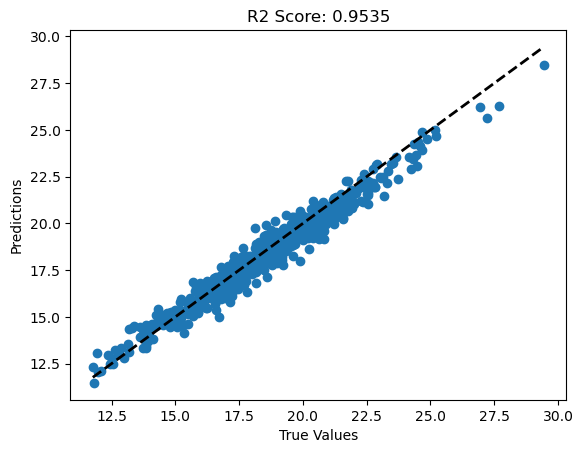

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
# Calculate metrics
r2 = r2_score(Y_val_tensor.numpy(), val_outputs.numpy())

plt.scatter(Y_val_tensor.numpy(), val_outputs.numpy())
plt.plot([Y_val_tensor.min(), Y_val_tensor.max()], [Y_val_tensor.min(), Y_val_tensor.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'R2 Score: {r2:.4f}')

In [14]:
import evaluators

evaluators.evaluate_aero(model)

0.9563784003257751